In [134]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [135]:
path = PureWindowsPath(os.getcwd() + "\\data\\input\\data.parquet")
path = path.as_posix()
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus["category_bin"] = np.select([corpus["category"] == "philosophy"], [1], default=0)
corpus = corpus.sample(frac=1).reset_index(drop=True)
# corpus["category_bin"] = (corpus["category_bin"] == "philosophy")
# corpus

#preprocessing qui aurait du etre fait avant :
#enlever les retours a la ligne
corpus.replace("\\n", " ", regex=True, inplace=True)

#supprimer les doublons
print("corpus.shape =", corpus.shape)
corpus.drop_duplicates("message", inplace=True, keep="first")
print("corpus.shape =", corpus.shape)

# corpus.shape = (4007, 6) si False
# corpus.shape = (4649, 6) si first


corpus.shape = (8228, 6)
corpus.shape = (4649, 6)


In [136]:
zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())

(1825, 6)
0    1825
1    1825
Name: category_bin, dtype: int64


In [137]:
from sklearn.svm import SVC

model = SVC()
X = corpus["message_preprocessed"]
y = corpus["category"]
# y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# y_train.value_counts()
# print(indices_train, indices_test)
# indices_test
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
model.fit(X_train_tfidf, y_train)

SVC()

In [138]:
# Poids globaux (dans le corpus) des mots tfidf
print("X_train_tfidf.shape =", X_train_tfidf.shape)
n_words = X_train_tfidf.shape[1]
scores_tfidf = pd.DataFrame({"id":range(n_words), "words":tfidf_vectorizer.get_feature_names(), "idf":tfidf_vectorizer.idf_})
scores_tfidf = scores_tfidf.sort_values("idf", ascending=False)
print("moyenne des poids idf =", np.mean(scores_tfidf["idf"]))
print("ecart-type des poids idf =", np.std(scores_tfidf["idf"]))
with pd.option_context("display.max_rows", 100):
    display(scores_tfidf)
# scores_tfidf.to_csv("./data/output/scores_tfidf_train.csv")

X_train_tfidf.shape = (2445, 9513)
moyenne des poids idf = 7.523959689133691
ecart-type des poids idf = 0.8787645674724075


c:\Users\eupho\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,id,words,idf
0,0,aaaayaajpgpadqthechildofthecovenantorhowchristianparentsshouldtrainuptheirhouseholds,8.109062
5221,5221,matiere,8.109062
5242,5242,maçon,8.109062
5241,5241,may,8.109062
5240,5240,maximum,8.109062
...,...,...,...
1300,1300,cette,2.867315
6311,6311,plus,2.828400
9490,9490,être,2.666644
1545,1545,comme,2.653741


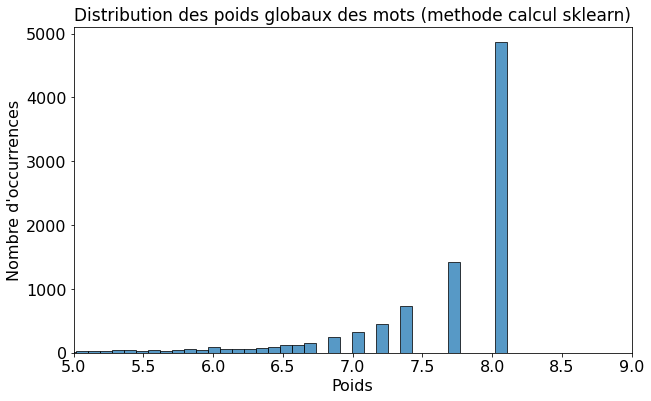

In [139]:
# Distribution des poids globaux des mots (calcules avec sklearn)
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution.png")
path = path.as_posix()

sb.histplot(data=scores_tfidf, x="idf")
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids globaux des mots (methode calcul sklearn)", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(5, 9)
plt.savefig(path)
plt.show()

In [140]:
# Calcul manuel des poids
print("X_train_tfidf.shape =", X_train_tfidf.shape)
words_weights = X_train_tfidf.sum(axis=0)
print("words_weights.shape =", words_weights.shape)
print(words_weights)
print(words_weights.shape)
words_weights = np.ravel(words_weights)
print(words_weights)
print(words_weights.shape)
# words_weights[:10]
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.unique(words_weights).shape
np.max(words_weights)
np.min(words_weights)
print("words_weights.shape =", words_weights.shape)
words_weights

X_train_tfidf.shape = (2445, 9513)
words_weights.shape = (1, 9513)
[[0.286 0.851 0.183 ... 0.113 0.338 0.138]]
(1, 9513)
[0.286 0.851 0.183 ... 0.113 0.338 0.138]
(9513,)
words_weights.shape = (9513,)


array([0.286, 0.851, 0.183, ..., 0.113, 0.338, 0.138])

In [141]:
# scores_tfidf["manuel_weights"] = words_weights
print("corpus.shape =", corpus.shape)
print("scores_tfidf.shape =", scores_tfidf.shape)
scores_tfidf

corpus.shape = (3650, 6)
scores_tfidf.shape = (9513, 3)


,id,words,idf
0,0,aaaayaajpgpadqthechildofthecovenantorhowchristianparentsshouldtrainuptheirhouseholds,8.109062
5221,5221,matiere,8.109062
5242,5242,maçon,8.109062
5241,5241,may,8.109062
5240,5240,maximum,8.109062
...,...,...,...
1300,1300,cette,2.867315
6311,6311,plus,2.828400
9490,9490,être,2.666644
1545,1545,comme,2.653741


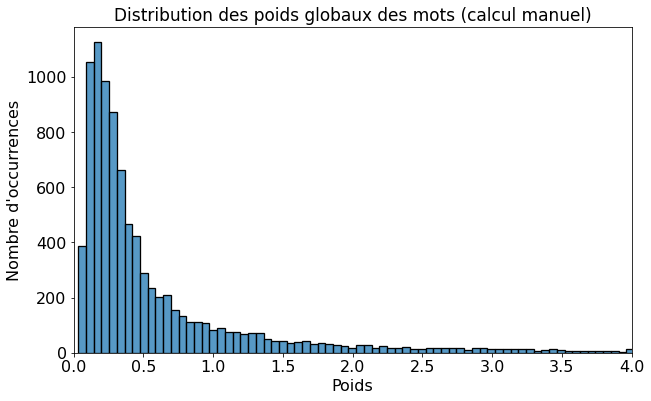

In [142]:
# Distribution des poids globaux des mots (calcules avec a la main)
# Pour chaque phrase, y a-t-il beaucoup de mots qui ont ete trouves et qui ont influences positivement la prediction ?
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution_manuel.png")
path = path.as_posix()

# sb.histplot(words_weights[:100000])
sb.histplot(words_weights, edgecolor="black", linewidth=1.3)
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids globaux des mots (calcul manuel)", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 4)
plt.savefig(path)
plt.show()

In [143]:
# Calcul des poids locaux des mots (poids des mots pour chaque document)
# Technique : ne plus travailler sur la matrice creuse mais la convertir en numpy array X_train_tfidf.toarray()
# pour travailler dessus
threshold_score = 4.5
col_top_words = [] #liste des top words pour chaque exemple du corpus (partie train)

feature_names = tfidf_vectorizer.get_feature_names_out()
X_train_tfidf_arr = X_train_tfidf.toarray()
idx_vocab = np.argsort(X_train_tfidf_arr, axis=1)
vocab = tfidf_vectorizer.vocabulary_
vocab_inv = {v: k for k, v in vocab.items()}
idx_top_words = idx_vocab[:,-10:]
idx_top_words = np.flip(idx_top_words, axis=1)

col_top_words = []
for idx_row in range(len(idx_top_words)):
    row_matrix_top_words_idx = idx_top_words[idx_row]
    doc_top_words = []
    for idx_word in row_matrix_top_words_idx:
        word = vocab_inv[idx_word]
        score = str(round(X_train_tfidf_arr[idx_row, idx_word], 3))
        doc_top_words.append(word + " (" + score + ")")
    col_top_words.append(doc_top_words)

df_train = pd.DataFrame(X_train_tfidf_arr, columns = feature_names)
df_train["id"] = list(indices_train)
df_train["top_words"] = col_top_words
df_train.sort_values("id", inplace=True)
df_train["message"] = corpus.iloc[indices_train].sort_values("id")["message"].values

display(df_train[["message", "top_words"]])

,message,top_words
2197,"> Il ne le semble pas, car S. Augustin écrit : “ Un être qui se comprend est > fini pour lui-même. ” Or, Dieu est de toute manière infini : donc il ne peut > se comprendre lui-même. – Ia, Q14, a3","[lui (0.393), même (0.36), fini (0.301), infini (0.291), comprend (0.281), semble (0.23), manière (0.224), augustin (0.222), comprendre (0.221), ia (0.219)]"
931,"Lévitique 16:11 : « Aaron offrira son taureau expiatoire, et il fera l’expiation **pour lui et pour sa maison**. Il égorgera son taureau expiatoire. »","[taureau (0.552), expiatoire (0.531), égorgera (0.29), aaron (0.266), offrira (0.266), expiation (0.251), lévitique (0.229), fera (0.218), maison (0.158), ethnos (0.0)]"
1425,"Genèse 45:8 : « Ce n’est donc pas vous qui m’avez envoyé ici, mais c’est Dieu; il m’a établi père de Pharaon, maître **de toute sa maison** , et gouverneur de tout le pays d’Egypte. »","[gouverneur (0.374), pharaon (0.327), établi (0.321), maître (0.316), egypte (0.316), envoyé (0.316), pays (0.285), genèse (0.255), maison (0.214), ici (0.193)]"
1951,"Je tiens tout de même à répondre à ce que Guillaume dit sur l’alliance avec Noé : elle ne serait pas sur le modèle suzerain-vassal et donc nous pouvons penser qu’il en est de même pour la Nouvelle alliance. Je pourrais dire que nous avons au contraire des indices positifs que la nouvelle alliance est sur ce modèle, que la Bible fait plutôt le parallèle entre la Nouvelle et l’Abrahamique qu’avec celle de Noé, etc. Mais surtout j’aimerais dire que cela passe à côté du point que nous soulignons : même dans le cas de Noé en Genèse 9, ce sont « lui et ses descendants » qui sont concernés.","[noé (0.433), nouvelle (0.294), modèle (0.286), alliance (0.23), soulignons (0.182), pourrais (0.182), suzerain (0.176), aimerais (0.176), concernés (0.176), positif (0.17)]"
1429,"2. [La profession de foi est-elle la preuve de l'élection ? (réponse au Bon Combat sur le baptême) - Par la foi](https://parlafoi.fr/2020/03/10/la-profession-de-foi-est-elle-la-preuve-de-lelection-reponse-au-bon-combat-sur-le-bapteme/) \- […] nous fait parvenir sa grâce », il remplit bien la définition de ce que l’on appelle « l’administration » de l’alliance. Ainsi,…","[profession (0.335), preuve (0.316), combat (0.297), elle (0.249), de (0.244), bon (0.244), lelection (0.216), est (0.205), remplit (0.202), foihttpsparlafoifrla (0.189)]"
...,...,...
364,"Parmi les objections souvent avancées lorsqu’une personne se déclare pédobaptiste au sein des milieux évangéliques, on entend souvent que les Réformateurs n’ont maintenu le pédobaptisme uniquement en raison d’idées politiques ou de pression sociale.","[souvent (0.347), maintenu (0.28), pression (0.28), sociale (0.261), avancée (0.255), politique (0.236), entend (0.236), réformateur (0.229), déclare (0.224), sein (0.213)]"
460,"> (i) La nouvelle alliance est « l’aboutissement de toute l’histoire > antérieure qui visait le Christ ». Le temps de l’Église est celui de la > πλήρωμα τοῦ χρόνου (plénitude des temps). La continuité dans l’histoire de > la rédemption est fondamentale. > > (ii) Le contraste entre le temps de l’attente et celui de l’accomplissement > est marqué par une dualité : Moïse et Jésus-Christ, la Loi et la Grâce (Jn > 1.17), l’ancienne et la nouvelle alliance, la lettre et l’Esprit (2 Cor 3 ; > cf. Hb 8.1-10.18), etc. > > (iii) L’exégèse de l’apôtre Paul en Galates 3-4 met en évidence une autre > dualité au sein de l’Ancien Testament : au régime de la Loi et de ses œuvres > s’oppose le régime abrahamique de la promesse et de la foi. Les membres de > la nouvelle alliance sont enfants d’Abraham. La théologie des alliances ne > s’articule pas seulement autour de Moïse et de Jésus, mais aussi autour > d’Abraham. L’accent néotestamentaire doit être respecté : le rapport avec > Abraham est d’abord celui de la continuité, le rapport avec Moïse celui de > la discontinuité. > > (iv) Cette articulation n’est pas seulement chronologique : la Loi advenue > sous Moïse